# A map of the hot jupiter HD 189733b
This notebook applies `starry` to real data: the secondary eclipse of HD 189733b measured in Knutson et al. (2007). Here we'll try to recover the hotspot offset found in Majeau et al. (2012). We assume the orbital parameters are known exactly and that the planet map is given by a dipole (a linear combination of $l = 1$ spherical harmonics) that rotates at the same period as the orbit. We're going to solve for the three $l = 1$ spherical harmonic coefficients and the planet luminosity.

In [3]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import emcee, corner
import starry

In [7]:
# Import some stuff and perform some hacks
import warnings
warnings.filterwarnings('ignore')
from matplotlib import gridspec
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
rcParams["figure.figsize"] = [4,3]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = False

# Add project scripts directory to path
sys.path.insert(1, os.path.join(os.path.dirname(os.path.dirname(os.path.abspath("."))), "tex/figures"))
%matplotlib inline

Let's import the routines that do the heavy lifting from the `hd189733b` script in the `tex/figures` directory of the `starry` repo:

In [8]:
import hd189733b as hd189

We can easily load and plot the data set:

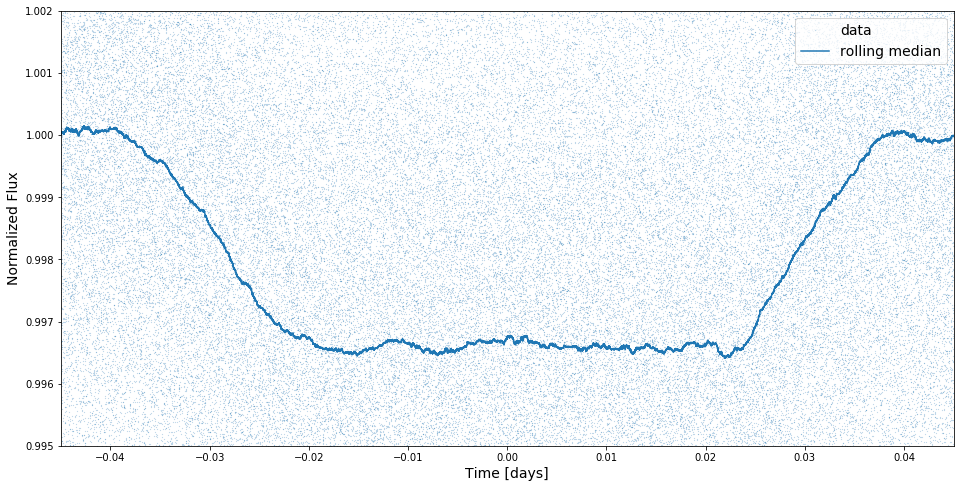

In [9]:
data = hd189.EclipseData(plot = True)

We have over 100,000 observations near secondary eclipse (blue points). The rolling median is shown as the blue curve, where the secondary eclipse of the hot jupiter is clearly visible.

## Use **gradients** to find Maximum Likelihood Solution

Let's instantiate our system and the `MaxLikeCartography` object, which wraps all the inference stuff we'll need:

In [13]:
star, planet, system = hd189.instantiate_HD189()
mlg = hd189.MaxLikeCartography(data.time, data.y, data.yerr, system, planet, N = 1, jac = True)

Let's compute the maximum likelihood map coefficients and luminosity using gradient descent:

In [14]:
mlg.compute()

  0%|          | 0/1 [00:00<?, ?it/s]

Finding maximum likelihood solution with gradients from 1 random parameter initializations...


100%|██████████| 1/1 [02:22<00:00, 142.32s/it]


That took about 2 minutes. Let's look at the result:

In [15]:
mlg.res

      fun: 0.5015234517674482
 hess_inv: array([[ 6.25929264e+02,  2.30208542e+03,  2.74707643e+02,
        -3.45286464e+00],
       [ 2.30208542e+03,  1.37523053e+04,  1.46259584e+03,
        -2.04771638e+01],
       [ 2.74707643e+02,  1.46259584e+03,  2.35651827e+02,
        -2.20065566e+00],
       [-3.45286464e+00, -2.04771638e+01, -2.20065566e+00,
         3.05155435e-02]])
      jac: array([-3.81340172e-06, -3.96006476e-05,  6.85155527e-06, -2.47076555e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 112
      nit: 72
     njev: 98
   status: 2
  success: False
        x: array([0.11027265, 0.54106669, 0.15897103, 0.00206277])

Our loss function `fun` (essentiall the chi-squared) looks good: it's quite small! The derivatives `jac` are also pretty small, so it looks like we found a minimum. The `x` parameters at the bottom are the coefficients of the $Y_{1,-1}$, $Y_{1,0}$, and $Y_{1,1}$ harmonics and the total luminosity of the planet in units of the star's luminosity. Let's plot our inferred model:

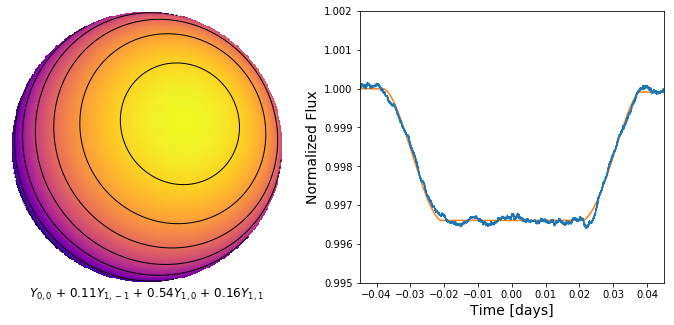

In [16]:
mlg.plot_ml_solution(data)

## Run MCMC

Now that we have a good model, let's initialize an MCMC run in the vicinity of these parameters so we can do some actual inference and get some uncertainties.

In [10]:
chain_path = "map_chain.npz"
grad = False
N = 2           # Number of ML fits
nsteps = 200    # Number of MCMC steps
nwalk = 40      # Number of MCMC walkers
std_ball = [0.01, 0.01, 0.01, 0.001]

# Load HD189 secondary eclipse data
data = hd189.EclipseData(plot = False)

# If there are no saved chains in this path 
if not os.path.exists(chain_path):
    
    # Use above results 
    results = mlg
    
    # Initialize system *without gradients*
    star, planet, system = hd189.instatiate_HD189(grad = False)
    
    # Initialize MCMC walkers *from maximum likelihood optimized solution*
    p0 = emcee.utils.sample_ball(results.res.x, std_ball, nwalk)
    
    # Run MCMC
    mcmc = hd189.MCMCCartography(data.time, data.y, data.yerr, system, planet, p0 = p0, 
                                 chain_path = chain_path)
    mcmc.run_mcmc(nsteps=nsteps)
    
    mcmc.save_chain()
        
else:
    
    # Read-in saved chain
    mcmc = hd189.MCMCCartography(data.time, data.y, data.yerr, system, planet, 
                                 chain_path = chain_path)

Loading MCMC chains from a saved state...


In the example above we only took 200 steps. But if you were willing to wait several hours and take *ten thousand* steps (almost certainly overkill!), here's what the chains would look like:

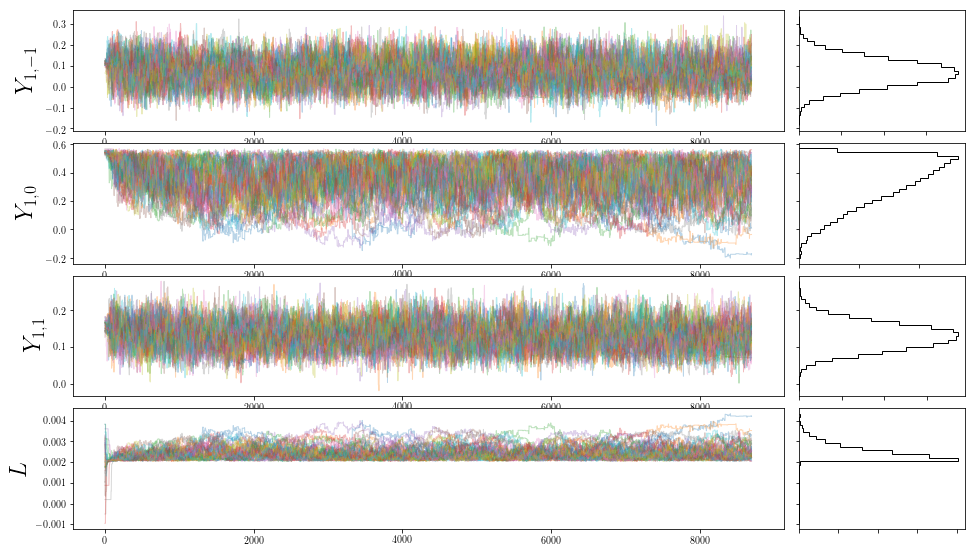

In [11]:
mcmc.plot_trace()

Here's the highest likelihood model for reference:

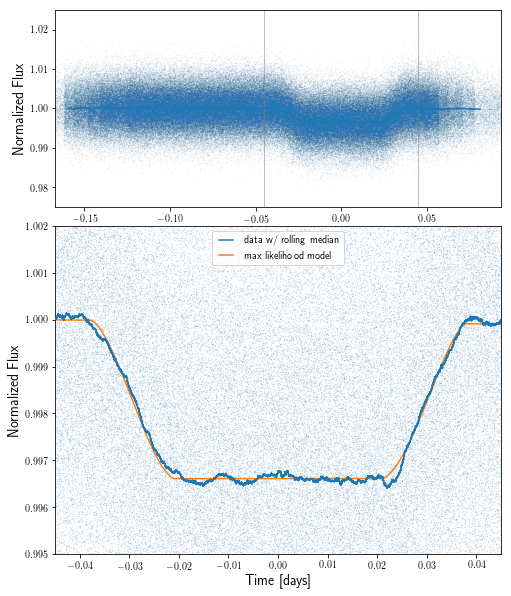

In [13]:
mcmc.plot_fit_full(data)

Let's look at our posteriors! (Again, in the figure below we ran 10,000 steps, so we're applying a generous burn-in of 2,000 steps.)

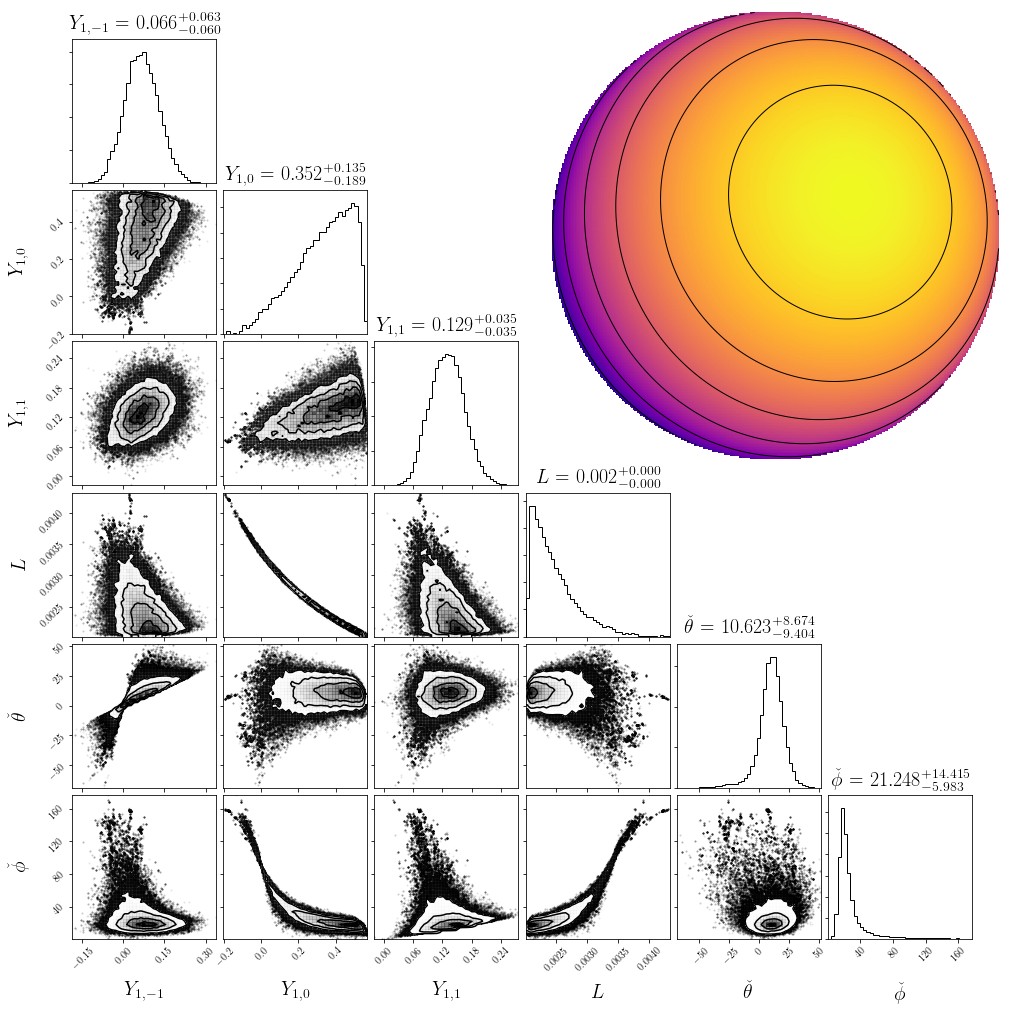

In [14]:
mcmc.apply_burnin(nburn=2000)
mcmc.get_hot_spot_samples()
mcmc.plot_corner_with_map()

Nice! Note that the last two columns of the corner plot are the inferred latitude and longitude of the hotspot. We've detected a statistically significant eastward shift in HD 1897833b!